In [473]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.cluster import DBSCAN
from imblearn.pipeline import Pipeline
from sklearn.cluster import KMeans
import lightgbm as lgb
from sklearn.decomposition import PCA
from sklearn.cluster import SpectralClustering
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import precision_score, make_scorer
from statistics import mean
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
import pandas as pd

In [474]:
# Model selected features
# features = ['reached_negative_balance', 'RAB_mean', 'RAB_min', 'ratio_RAB', 'RAB_max', 'credit_ratio', 'withdrawal_ratio', 'IC_mean', 'balance_min', 'RAB_sum', 'mean_trans_profit', 'RAB', 'balance_mean', 'ratio_CC', 'CC_std', 'IC_min', 'CC_max', 'ratio_IC']
# Used for best submission
features = ['reached_negative_balance', 'RAB_mean', 'ratio_RAB', 'credit_ratio', 'balance_min', 'RAB_sum', 'mean_trans_profit', 'balance_mean', 'ratio_CC', 'CC_std', 'IC_min', 'CC_max', 'ratio_IC', 'withdrawal_max', 'WC_max', 'last_balance', 'CAB_mean']
# features = ['reached_negative_balance', 'RAB_mean', 'RAB_min', 'ratio_RAB', 'RAB_max', 'credit_ratio', 'withdrawal_ratio', 'IC_mean', 'balance_min', 'RAB_sum', 'mean_trans_profit', 'RAB', 'balance_mean', 'ratio_CC', 'CC_std', 'IC_min', 'CC_max', 'ratio_IC', 'withdrawal_max', 'WC_max']

X_test_full = pd.read_csv("./preprocessed/mergedTestData.csv")
X_test_pred = X_test_full[features]

def read_clustering_data():
  X_train_full = pd.read_csv("./preprocessed/mergedTrainData.csv")
  X_train = X_train_full[features]

  # Positive class now is 1 and negative class now is 0
  X_train_full.loc[X_train_full["status"] == 1, "status"] = 0
  X_train_full.loc[X_train_full["status"] == -1, "status"] = 1

  y_train = X_train_full.status

  return [X_train, y_train]

# Descriptive Models (Visualization)

`https://towardsdatascience.com pca-using-python-scikit-learn-e653f8989e60`

- Use StandardScaler

- Apply PCA algorithm

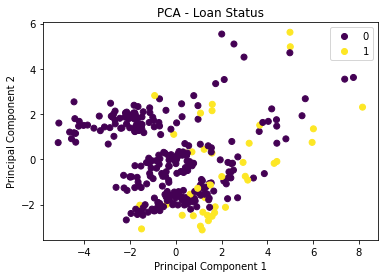

In [475]:
[X_train, y_train] = read_clustering_data()

pca = PCA(n_components=2)
pipeline = Pipeline([('scaler', StandardScaler()), ('pca', pca)])
components = pipeline.fit_transform(X_train)
scatter = plt.scatter(components[:,0],  components[:,1], c=y_train)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA - Loan Status")

labels = np.unique(y_train)
handles = [plt.Line2D([],[],marker="o", ls="", color=scatter.cmap(scatter.norm(yi))) for yi in labels]
plt.legend(handles, labels)
plt.show()

In [476]:
[X_train, y_train] = read_clustering_data()

pca = PCA(n_components=3)
pipeline = Pipeline([('scaler', StandardScaler()), ('pca', pca)])
components = pipeline.fit_transform(X_train)

total_var = pca.explained_variance_ratio_.sum() * 100

fig = px.scatter_3d(
    components, x=0, y=1, z=2, color=y_train,
    title=f'Total Explained Variance: {total_var:.2f}%',
    labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'}
)
fig.show()

In [477]:
[X_train, y_train] = read_clustering_data()

n_components = 4
pca = PCA(n_components)
pipeline = Pipeline([('scaler', StandardScaler()), ('pca', pca)])
components = pipeline.fit_transform(X_train)
labels = {
    str(i): f"PC{i+1} ({var:.1f}%)"
    for i, var in enumerate(pca.explained_variance_ratio_ * 100)
}

fig = px.scatter_matrix(
    components,
    labels=labels,
    dimensions=range(n_components),
    color=y_train
)
fig.update_traces(diagonal_visible=False)
fig.show()

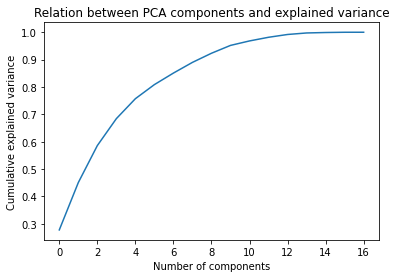

In [478]:
# https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html
[X_train, y_train] = read_clustering_data()

pca = PCA()
pipeline = Pipeline([('scaler', StandardScaler()), ('pca', pca)])
components = pipeline.fit(X_train)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title("Relation between PCA components and explained variance")
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.show()


A vital part of using PCA in practice is the ability to estimate how many components are needed to describe the data. This can be determined by looking at the cumulative explained variance ratio as a function of the number of components:
This curve quantifies how much of the total, 17-dimensional variance is contained within the first N components. For example, we see that with the digits the first 4 components contain approximately 75% of the variance, while you need around 12 components to describe close to 100% of the variance.
Here we see that our two-dimensional projection loses a lot of information (as measured by the explained variance) and that we'd need about 7 components to retain 90% of the variance. Looking at this plot for a high-dimensional dataset can help understand the level of redundancy present in multiple observations.

# K-Means

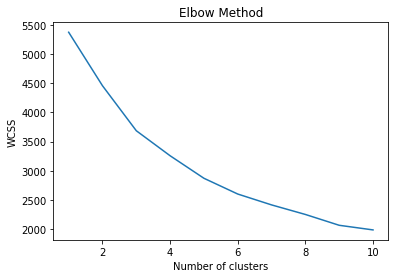

In [479]:
[X_train, y_train] = read_clustering_data()
wcss = []

X_train = StandardScaler().fit_transform(X_train)

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X_train)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

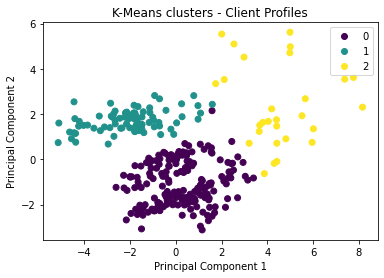

In [480]:
[X_train, y_train] = read_clustering_data()
                        
X_train = StandardScaler().fit_transform(X_train)
kmeans = KMeans(n_clusters=3, random_state=4).fit(X_train)
clientProfiles = kmeans.labels_

pca = PCA(n_components=2)
components = pca.fit_transform(X_train)
scatter = plt.scatter(components[:,0], components[:,1], c=clientProfiles)
plt.title("K-Means clusters - Client Profiles")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")

labels = np.unique(kmeans.labels_)
handles = [plt.Line2D([],[],marker="o", ls="", color=scatter.cmap(scatter.norm(yi))) for yi in labels]
plt.legend(handles, labels)
plt.show()

# Spoiler alert, we will add this column to our model.

# Train Data
merge_train_data = pd.read_csv("./preprocessed/mergedTrainData.csv", sep=",")
merge_train_data["client_profile"] = clientProfiles
merge_train_data.to_csv("./preprocessed/mergedTrainData.csv", index=None)

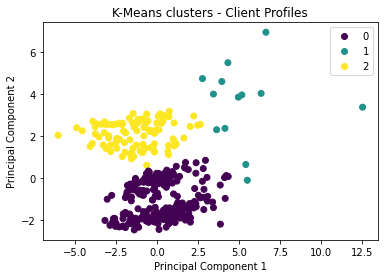

In [481]:
X_test_data = StandardScaler().fit_transform(X_test_pred)
kmeans = KMeans(n_clusters=3, random_state=4).fit(X_test_data)
clientProfiles = kmeans.labels_

pca = PCA(n_components=2)
components = pca.fit_transform(X_test_data)
scatter = plt.scatter(components[:,0], components[:,1], c=clientProfiles)
plt.title("K-Means clusters - Client Profiles")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")

labels = np.unique(kmeans.labels_)
handles = [plt.Line2D([],[],marker="o", ls="", color=scatter.cmap(scatter.norm(yi))) for yi in labels]
plt.legend(handles, labels)
plt.show()

# Spoiler alert, we will add this column to our model.

# Test Data
merge_test_data = pd.read_csv("./preprocessed/mergedTestData.csv", sep=",")
merge_test_data["client_profile"] = clientProfiles
merge_test_data.to_csv("./preprocessed/mergedTestData.csv", index=None)

# Spectral Clustering

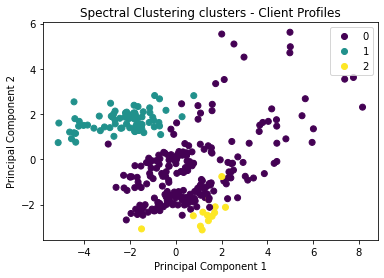

In [482]:
# https://jakevdp.github.io/PythonDataScienceHandbook/05.11-k-means.html
[X_train, y_train] = read_clustering_data()

X_train = StandardScaler().fit_transform(X_train)
kmeans = SpectralClustering(n_clusters=3, affinity='nearest_neighbors', assign_labels='kmeans', random_state=4)
labels = kmeans.fit_predict(X_train)                          

pca = PCA(n_components=2)
components = pca.fit_transform(X_train)
scatter = plt.scatter(components[:,0], components[:,1], c=labels)
plt.title("Spectral Clustering clusters - Client Profiles")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")

labels = np.unique(labels)
handles = [plt.Line2D([],[],marker="o", ls="", color=scatter.cmap(scatter.norm(yi))) for yi in labels]
plt.legend(handles, labels)
plt.show()

# DBScan

In [483]:
# DBSCAN
[X_train, y_train] = read_clustering_data()

X_train = StandardScaler().fit_transform(X_train)

pca = PCA(n_components=3)
components = pca.fit_transform(X_train)
pca_df = pd.DataFrame(components, columns=['pc1', 'pc2', 'pc3'])
# print(pca.explained_variance_ratio_)

db = DBSCAN(eps=0.65, min_samples=8).fit(pca_df)
labels = db.labels_
# print(labels)

no_clusters = len(np.unique(labels) )
no_noise = np.sum(np.array(labels) == -1, axis=0)

print('Estimated no. of clusters: %d' % no_clusters)
print('Estimated no. of noise points: %d' % no_noise)

# print(components)
fig = px.scatter_3d(
    components, x=0, y=1, z=2, color=labels,
    title=f"DBScan Clustering - {no_clusters} clusters and {no_noise} noise points",
    labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'}
)
fig.show()

# https://towardsdatascience.com/machine-learning-algorithms-part-9-k-means-example-in-python-f2ad05ed5203
# https://towardsdatascience.com/explaining-dbscan-clustering-18eaf5c83b31

Estimated no. of clusters: 5
Estimated no. of noise points: 173


In [484]:
X_test_pred["client_profile"] = clientProfiles
features.append("client_profile")

/tmp/ipykernel_21540/2103385979.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [485]:
algorithms = []
metrics = {}
plots_data = {}

scoring = {
  "precision_score": make_scorer(precision_score, zero_division=0),
  "recall_score": "recall",
  "roc_auc_score": "roc_auc",
  "f1_score": "f1",
  "accuracy_score": "accuracy",
}

def run_model(pipeline, param_grid, X_train, y_train, X_test_pred, clfName, X_test=[], y_test=[]):
  global algorithms, metrics, plots_data
  
  # Define evaluation procedure
  cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

  grid = GridSearchCV(estimator=pipeline, param_grid=param_grid, 
    scoring=scoring, n_jobs=-1, cv=cv, refit="roc_auc_score")

  grid_result = grid.fit(X_train, y_train)
  print('Best: %f using %s' % (grid_result.best_score_, grid_result.best_params_))

  # Evaluate the model
  p_pred = grid_result.predict_proba(X_test_pred)

  # ROC Curve & PR 
  estimator = grid_result.best_estimator_

  if SAMPLING:
    plots_data[clfName] = [estimator, X_test, y_test]
    
    RocCurveDisplay.from_estimator(estimator, X_test, y_test)
    PrecisionRecallDisplay.from_estimator(estimator, X_test, y_test)
  else:
    plots_data[clfName] = [estimator, X_train, y_train]
    
    RocCurveDisplay.from_estimator(estimator, X_train, y_train)
    PrecisionRecallDisplay.from_estimator(estimator, X_train, y_train)
  
  mean_fit_time = mean(grid_result.cv_results_.get('mean_fit_time'))
  mean_accuracy_score = mean(grid_result.cv_results_.get('mean_test_accuracy_score'))
  mean_precision_score = mean(grid_result.cv_results_.get('mean_test_precision_score'))
  mean_recall_score = mean(grid_result.cv_results_.get('mean_test_recall_score'))
  mean_roc_auc_score = mean(grid_result.cv_results_.get('mean_test_roc_auc_score'))
  mean_f1_score = mean(grid_result.cv_results_.get('mean_test_f1_score'))

  algorithms.append(clfName)
  metrics[clfName] = {}
  
  metrics[clfName]["fit_time"] = mean_fit_time
  metrics[clfName]["accuracy"] = mean_accuracy_score
  metrics[clfName]["precision"] = mean_precision_score
  metrics[clfName]["recall"] = mean_recall_score
  metrics[clfName]["roc_auc"] = mean_roc_auc_score
  metrics[clfName]["f1"] = mean_f1_score

  print("----------------- Metrics: -----------------")
  print("Mean Fit Time: " + str(mean_fit_time))
  print("Mean Accuracy Score: " + str(mean_accuracy_score))
  print("Mean Precision Score: " + str(mean_precision_score))
  print("Mean Recall Score: " + str(mean_recall_score))
  print("Mean Roc-Auc Score: " + str(mean_roc_auc_score))
  print("Mean F1 Score: " + str(mean_f1_score))

  resultData = {'Id': X_test_full['loan_id'], 'Predicted': p_pred[:,1]}
  result = pd.DataFrame(data=resultData)
  return result

def encode_df(df):
  columnsToEncode = list(df.select_dtypes(include=['object']))
  le = LabelEncoder()
  for feature in columnsToEncode:
      try:
          df[feature] = le.fit_transform(df[feature])
      except:
          print('Error encoding ' + feature)
  return df

def load_data():
  X_train_full = pd.read_csv("./preprocessed/mergedTrainData.csv")

  X_train = X_train_full[features]
  
  # Positive class now is 1 and negative class now is 0
  X_train_full.loc[X_train_full["status"] == 1, "status"] = 0
  X_train_full.loc[X_train_full["status"] == -1, "status"] = 1
  
  y_train = X_train_full.status
  
  if SAMPLING:
    X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.25, stratify=y_train, random_state=0)
    return [X_train, X_test, X_test_pred, y_train, y_test]
  else:
    return [X_train, X_test_pred, y_train]

## Logistic Regression
Logistic Regression is a Machine Learning classification algorithm that is used to predict the probability of a categorical dependent variable. In logistic regression, the dependent variable is a binary variable that contains data coded as 1 (yes, success, etc.) or 0 (no, failure, etc.). In other words, the logistic regression model predicts P(Y=1) as a function of X.

------- WITH UNDERSAMPLING -------
Best: 0.907864 using {'classification__C': 0.05, 'classification__class_weight': 'balanced', 'classification__penalty': 'l2', 'classification__solver': 'liblinear', 'under__sampling_strategy': 0.2}
----------------- Metrics: -----------------
Mean Fit Time: 0.05546293489516727
Mean Accuracy Score: 0.843213710605015
Mean Precision Score: 0.515082029082029
Mean Recall Score: 0.7165211640211641
Mean Roc-Auc Score: 0.888294422398589
Mean F1 Score: 0.5544321174856889


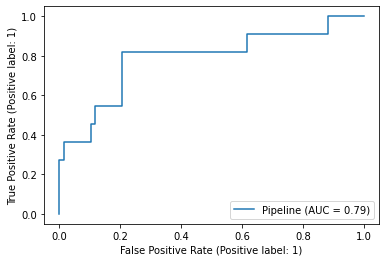

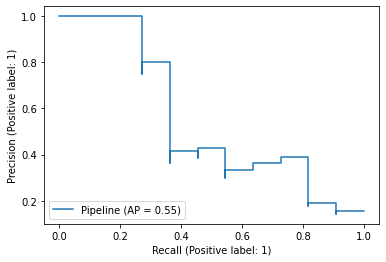

In [486]:
SAMPLING = True

# Load data
if SAMPLING: 
  [X_train, X_test, X_test_pred, y_train, y_test] = load_data() 
  X_test = encode_df(X_test)
else:
  [X_train, X_test_pred, y_train] = load_data()

X_train = encode_df(X_train)

# With Undersampling
print("------- WITH UNDERSAMPLING -------")
pipeline = Pipeline([('under', RandomUnderSampler(random_state=0)), ('scaler', StandardScaler()), ('classification', LogisticRegression(random_state=0, max_iter=10000))])

param_grid = {'under__sampling_strategy': [0.2, 0.25, 0.5, 0.75, 0.9, 0.99, 'majority'],
          'classification__penalty': ['l2'],
          'classification__C': [0.01, 0.05, 0.1, 0.2, 0.5, 1.0],
          'classification__solver': ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'],
          'classification__class_weight': ["balanced", None]}

results_df = run_model(pipeline, param_grid, X_train, y_train, X_test_pred, "LogisticRegression_Undersampling", X_test=X_test, y_test=y_test)
results_df.to_csv("./results/logisticRegressionUndersampling.csv", index=None)

------- WITHOUT OVERSAMPLING & UNDERSAMPLING -------
Best: 0.910509 using {'classification__C': 0.01, 'classification__class_weight': None, 'classification__penalty': 'l2', 'classification__solver': 'liblinear'}
----------------- Metrics: -----------------
Mean Fit Time: 0.02746950387954712
Mean Accuracy Score: 0.8690297906602256
Mean Precision Score: 0.5823254754504754
Mean Recall Score: 0.585925925925926
Mean Roc-Auc Score: 0.900657848324515
Mean F1 Score: 0.5160985264735265


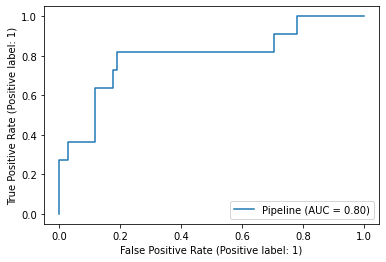

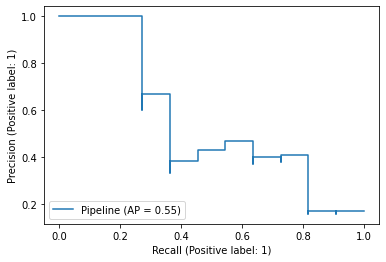

In [487]:
# Without Oversampling & Undersampling
print("------- WITHOUT OVERSAMPLING & UNDERSAMPLING -------")
pipeline = Pipeline([('scaler', StandardScaler()), ('classification', LogisticRegression(random_state=0, max_iter=10000))])

param_grid = {'classification__penalty': ['l2'],
          'classification__C': [0.01, 0.05, 0.1, 0.2, 0.5, 1.0],
          'classification__solver': ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'],
          'classification__class_weight': ["balanced", None]}

results_df = run_model(pipeline, param_grid, X_train, y_train, X_test_pred, "LogisticRegression", X_test=X_test, y_test=y_test)
results_df.to_csv("./results/logisticRegression.csv", index=None)

------- WITH OVERSAMPLING -------
Best: 0.909134 using {'classification__C': 0.05, 'classification__class_weight': None, 'classification__penalty': 'l2', 'classification__solver': 'liblinear', 'smote__sampling_strategy': 0.2}
----------------- Metrics: -----------------
Mean Fit Time: 0.04622989120937529
Mean Accuracy Score: 0.8505476478030827
Mean Precision Score: 0.5079287808752094
Mean Recall Score: 0.666223544973545
Mean Roc-Auc Score: 0.8947995401864449
Mean F1 Score: 0.5359558184708745


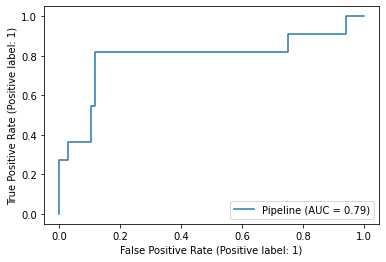

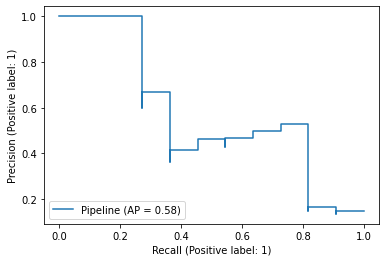

In [488]:
# With Oversampling
print("------- WITH OVERSAMPLING -------")
pipeline = Pipeline([('smote', SMOTE(random_state=0)), ('scaler', StandardScaler()), ('classification', LogisticRegression(random_state=0, max_iter=10000))])

weights = list(np.linspace(0.2, 0.9, 5)) + ['minority']
param_grid = {
        'smote__sampling_strategy': weights,
        'classification__penalty': ['l2'],
        'classification__C': [0.001, 0.01, 0.05, 0.1, 0.2, 0.5, 1.0],
        'classification__solver': ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'],
        'classification__class_weight': ["balanced", None]}

results_df = run_model(pipeline, param_grid, X_train, y_train, X_test_pred, "LogisticRegression_Oversampling", X_test=X_test, y_test=y_test)
results_df.to_csv("./results/logisticRegressionWithSMOTE.csv", index=None)

# Random Forest

------- WITH UNDERSAMPLING -------
Best: 0.896396 using {'classification__class_weight': None, 'classification__criterion': 'entropy', 'classification__max_features': 'sqrt', 'classification__n_estimators': 250, 'under__sampling_strategy': 0.2}
----------------- Metrics: -----------------
Mean Fit Time: 0.7342136750618616
Mean Accuracy Score: 0.8446432165861515
Mean Precision Score: 0.5435182679974346
Mean Recall Score: 0.6429398148148148
Mean Roc-Auc Score: 0.876361469356261
Mean F1 Score: 0.5325686530547642


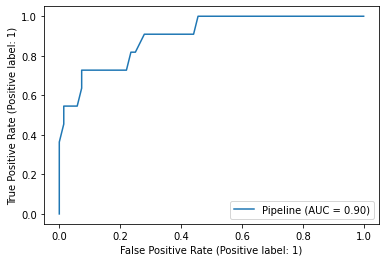

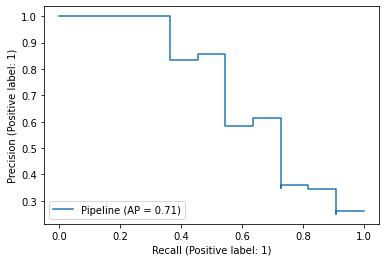

In [489]:
# https://stackoverflow.com/questions/30814231/using-the-predict-proba-function-of-randomforestclassifier-in-the-safe-and-rig
# https://rpmcruz.github.io/machine%20learning/2018/02/09/probabilities-trees.html

# Load data
if SAMPLING: 
  [X_train, X_test, X_test_pred, y_train, y_test] = load_data() 
  X_test = encode_df(X_test)
else:
  [X_train, X_test_pred, y_train] = load_data()

# With Undersampling
print("------- WITH UNDERSAMPLING -------")
pipeline = Pipeline([('under', RandomUnderSampler(random_state=0)), ('classification', RandomForestClassifier(random_state=0))])

param_grid = {'under__sampling_strategy': [0.2, 0.5, 0.75, 0.9],
            'classification__n_estimators': [50, 150, 250],
            'classification__max_features': ['sqrt', 'auto'],
            'classification__criterion': ['gini', 'entropy'],
            'classification__class_weight': ["balanced", "balanced_subsample", None],}

results_df = run_model(pipeline, param_grid, X_train, y_train, X_test_pred, "RandomForest_Undersampling", X_test=X_test, y_test=y_test)
results_df.to_csv("./results/randomForestUndersampling.csv", index=None)

------- WITHOUT OVERSAMPLING & UNDERSAMPLING -------
Best: 0.904428 using {'classification__class_weight': None, 'classification__criterion': 'entropy', 'classification__max_features': 'sqrt', 'classification__n_estimators': 50}
----------------- Metrics: -----------------
Mean Fit Time: 0.6800658612339585
Mean Accuracy Score: 0.9105072463768117
Mean Precision Score: 0.7515740740740741
Mean Recall Score: 0.4359567901234568
Mean Roc-Auc Score: 0.8907631540270429
Mean F1 Score: 0.5263712522045856


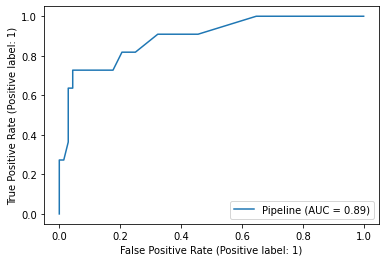

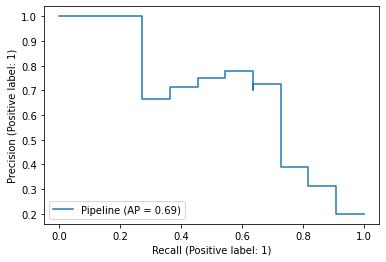

In [490]:
# Without Oversampling & Undersampling
print("------- WITHOUT OVERSAMPLING & UNDERSAMPLING -------")
param_grid = {'classification__n_estimators': [50, 150, 250],
              'classification__max_features': ['sqrt', 'auto'],
              'classification__criterion': ['gini', 'entropy'],
              'classification__class_weight': ["balanced", "balanced_subsample", None],
            }

pipeline = Pipeline([('classification', RandomForestClassifier(random_state=0))])
results_df = run_model(pipeline, param_grid, X_train, y_train, X_test_pred, "RandomForest", X_test=X_test, y_test=y_test)
results_df.to_csv("./results/randomForest.csv", index=None)

------- WITH OVERSAMPLING -------
Best: 0.906888 using {'classification__class_weight': 'balanced_subsample', 'classification__criterion': 'entropy', 'classification__max_features': 'sqrt', 'classification__n_estimators': 250, 'smote__sampling_strategy': 0.375}
----------------- Metrics: -----------------
Mean Fit Time: 0.7638176200198539
Mean Accuracy Score: 0.9000575908033639
Mean Precision Score: 0.6851774691358025
Mean Recall Score: 0.5785493827160494
Mean Roc-Auc Score: 0.8923100075935724
Mean F1 Score: 0.5899517886091961


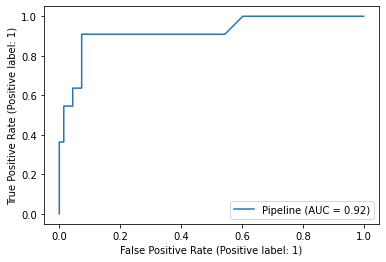

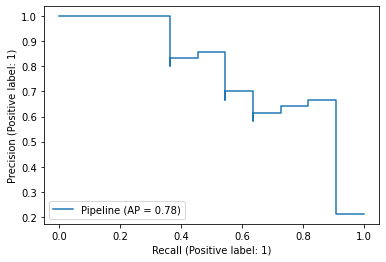

In [491]:
# With Oversampling
print("------- WITH OVERSAMPLING -------")
pipeline = Pipeline([('smote', SMOTE(random_state=0)), ('classification', RandomForestClassifier(random_state=0))])

weights = list(np.linspace(0.2, 0.9, 5)) + ['minority']
param_grid['smote__sampling_strategy'] = weights
results_df = run_model(pipeline, param_grid, X_train, y_train, X_test_pred, "RandomForest_Oversampling", X_test=X_test, y_test=y_test)
results_df.to_csv("./results/randomForestWithSMOTE.csv", index=None)

# SVM
Applying Min-Max Scaling so that values are normalized (0-1).

In [492]:
def min_max_scaling(df, numeric_columns):
  # copy the dataframe
  df_norm = df.copy()
  # apply min-max scaling
  for column in numeric_columns:
      df_norm[column] = (df_norm[column] - df_norm[column].min()) / (df_norm[column].max() - df_norm[column].min())
      
  return df_norm


------- WITH UNDERSAMPLING -------
Best: 0.902474 using {'classification__C': 1, 'classification__gamma': 0.1, 'classification__kernel': 'rbf', 'under__sampling_strategy': 0.75}
----------------- Metrics: -----------------
Mean Fit Time: 0.03589266434169951
Mean Accuracy Score: 0.8210010351966874
Mean Precision Score: 0.3416297816662488
Mean Recall Score: 0.45649603174603176
Mean Roc-Auc Score: 0.8513437169312169
Mean F1 Score: 0.3408586364957592


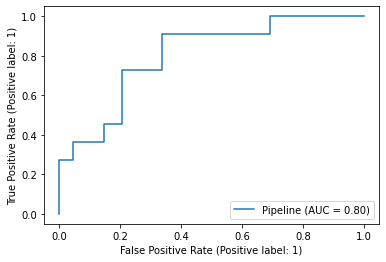

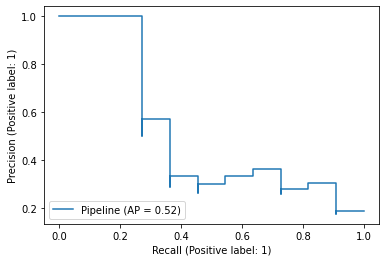

In [493]:
# https://towardsdatascience.com/support-vector-machine-introduction-to-machine-learning-algorithms-934a444fca47

# Load data
numeric_features = list(X_train.select_dtypes(include=['int64', 'float64']))

if SAMPLING: 
  [X_train, X_test, X_test_pred, y_train, y_test] = load_data() 
  X_test = min_max_scaling(X_test, numeric_features)
else:
  [X_train, X_test_pred, y_train] = load_data()

X_train = min_max_scaling(X_train, numeric_features)

# With Undersampling
print("------- WITH UNDERSAMPLING -------")
pipeline = Pipeline([('under', RandomUnderSampler(random_state=0)), ('classification', SVC(probability=True, random_state=0))])

param_grid = {'under__sampling_strategy': [0.2, 0.25, 0.5, 0.75, 0.9, 0.99, 'majority'],
            'classification__C': [0.1, 1, 10, 100, 1000],
            'classification__gamma': [1, 0.1, 0.01, 0.001, 0.0001],
            'classification__kernel': ['linear', 'poly', 'rbf', 'sigmoid']}

results_df = run_model(pipeline, param_grid, X_train, y_train, X_test_pred, "SVM_Undersampling", X_test=X_test, y_test=y_test)
results_df.to_csv("./results/SVMUndersampling.csv", index=None)


In [528]:
# Without Oversampling & Undersampling
print("------- WITHOUT OVERSAMPLING & UNDERSAMPLING -------")

clf = Pipeline([('classification', SVC(probability=True, random_state=0))])

param_grid = {'classification__C': [0.1, 1, 10, 100, 1000],
              'classification__gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'classification__kernel': ['linear', 'poly', 'rbf', 'sigmoid']}


results_df = run_model(pipeline, param_grid, X_train, y_train, X_test_pred, "SVM", X_test=X_test, y_test=y_test)
results_df.to_csv("./results/SVM.csv", index=None)

------- WITHOUT OVERSAMPLING & UNDERSAMPLING -------


KeyboardInterrupt: 

In [ ]:
# With Oversampling
print("------- WITH OVERSAMPLING -------")
pipeline = Pipeline([('smote', SMOTE(random_state=0)), ('classification', SVC(probability=True, random_state=0))])

weights = list(np.linspace(0.2, 0.9, 5)) + ['minority']
param_grid['smote__sampling_strategy'] = weights

results_df = run_model(pipeline, param_grid, X_train, y_train, X_test_pred, "SVM_Oversampling", X_test=X_test, y_test=y_test)
results_df.to_csv("./results/SVMWithSMOTE.csv", index=None)

------- WITH OVERSAMPLING -------


ValueError: Invalid parameter classifier for estimator Pipeline(steps=[('smote', SMOTE(random_state=0)),
                ('classification', SVC(probability=True, random_state=0))]). Check the list of available parameters with `estimator.get_params().keys()`.

# Light GBM

------- WITH UNDERSAMPLING -------
Best: 0.880357 using {'classifier__learning_rate': 0.01, 'classifier__max_depth': 25, 'classifier__n_estimators': 110, 'classifier__num_leaves': 10, 'under__sampling_strategy': 0.2}
----------------- Metrics: -----------------
Mean Fit Time: 0.07568977828379031
Mean Accuracy Score: 0.815414905394525
Mean Precision Score: 0.406680089949085
Mean Recall Score: 0.5572916666666666
Mean Roc-Auc Score: 0.8434911449147561
Mean F1 Score: 0.41814103721546964


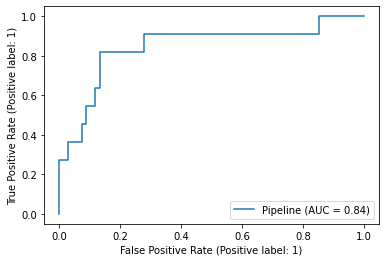

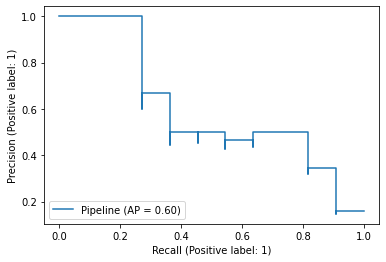

In [496]:
# Load data
if SAMPLING: 
  [X_train, X_test, X_test_pred, y_train, y_test] = load_data() 
  X_test = encode_df(X_test)
else:
  [X_train, X_test_pred, y_train] = load_data()

# With Undersampling
print("------- WITH UNDERSAMPLING -------")
pipeline = Pipeline([('under', RandomUnderSampler(random_state=0)), ('classifier', lgb.LGBMClassifier(random_state=0))])

param_grid = {'under__sampling_strategy': [0.2, 0.25, 0.5, 0.75, 0.9, 'majority'],
              'classifier__max_depth': [25, 50, 75],
              'classifier__learning_rate' : [0.01, 0.05, 0.1],
              'classifier__num_leaves': [int(x) for x in range(10, 100, 50)],
              'classifier__n_estimators': [int(x) for x in range(10, 200, 50)],
             }

results_df = run_model(pipeline, param_grid, X_train, y_train, X_test_pred, "LightGBM_Undersampling", X_test=X_test, y_test=y_test)
results_df.to_csv("./results/lightGBMUndersampling.csv", index=None)

------- WITHOUT OVERSAMPLING & UNDERSAMPLING -------
Best: 0.898525 using {'classifier__learning_rate': 0.1, 'classifier__max_depth': 25, 'classifier__n_estimators': 60, 'classifier__num_leaves': 2}
----------------- Metrics: -----------------
Mean Fit Time: 0.061545198935049554
Mean Accuracy Score: 0.8894977858293076
Mean Precision Score: 0.43509920634920635
Mean Recall Score: 0.25729166666666664
Mean Roc-Auc Score: 0.8578271053791887
Mean F1 Score: 0.307336860670194


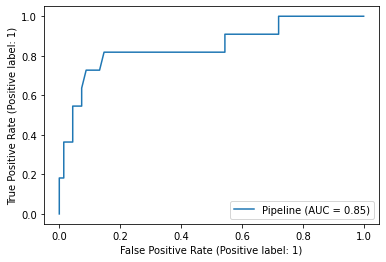

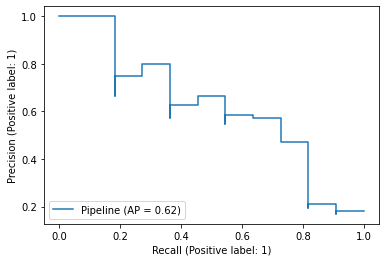

In [497]:
# Without Oversampling & Undersampling
print("------- WITHOUT OVERSAMPLING & UNDERSAMPLING -------")
pipeline = Pipeline([('classifier', lgb.LGBMClassifier(random_state=0))])

param_grid = {'classifier__max_depth': [25, 50, 75],
              'classifier__learning_rate' : [0.01, 0.05, 0.1],
              'classifier__num_leaves': [int(x) for x in range(2, 100, 50)],
              'classifier__n_estimators': [int(x) for x in range(10, 200, 50)],
             }

results_df = run_model(pipeline, param_grid, X_train, y_train, X_test_pred, "LightGBM", X_test=X_test, y_test=y_test)
results_df.to_csv("./results/lightGBM.csv", index=None)

------- WITH OVERSAMPLING -------
Best: 0.895992 using {'classifier__learning_rate': 0.05, 'classifier__max_depth': 25, 'classifier__n_estimators': 110, 'classifier__num_leaves': 2, 'smote__sampling_strategy': 0.2}
----------------- Metrics: -----------------
Mean Fit Time: 0.11478382812605964
Mean Accuracy Score: 0.875727573134729
Mean Precision Score: 0.5579355790814123
Mean Recall Score: 0.46763117283950617
Mean Roc-Auc Score: 0.8545398846266902
Mean F1 Score: 0.4614344615079909


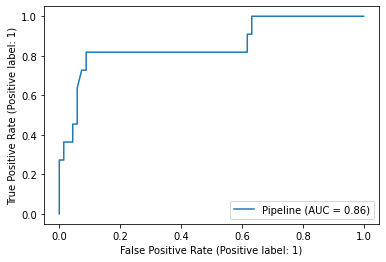

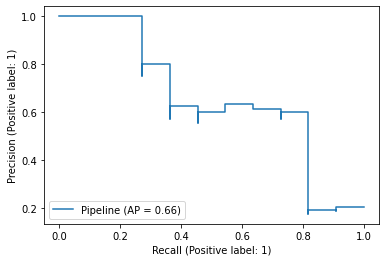

In [498]:
# With Oversampling
print("------- WITH OVERSAMPLING -------")
pipeline = Pipeline([('smote', SMOTE(random_state=0)), ('classifier', lgb.LGBMClassifier(random_state=0))])

weights = list(np.linspace(0.2, 0.9, 5)) + ['minority']
param_grid['smote__sampling_strategy'] = weights

results_df = run_model(pipeline, param_grid, X_train, y_train, X_test_pred, "LightGBM_Oversampling", X_test=X_test, y_test=y_test)
results_df.to_csv("./results/lightGBMSMOTE.csv", index=None)

# Barplots of all algorithms

In [499]:
def algorithms_comparison_plot(algorithms, title, colors, selectedMetric):
  values = [metrics[alg][selectedMetric] for alg in algorithms]

  fig = plt.figure()

  if len(colors) == 3:
    ax = fig.add_axes([0,0,1.25,1])
  else:
    ax = fig.add_axes([0,0,1.75,1])

  ax.bar(algorithms, values, color=colors)
  plt.xlabel("\n\n" + title, fontdict={"weight": "bold"})
  plt.ylabel("\n\nValue", fontdict={"weight": "bold"})
  plt.show()

# Logistic Regression

### F1 Measure

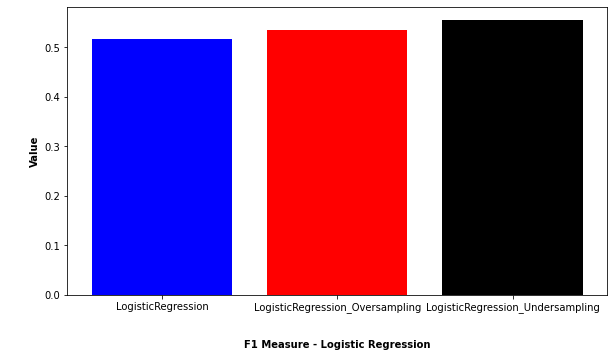

In [500]:
algorithms_comparison_plot(("LogisticRegression", "LogisticRegression_Oversampling", "LogisticRegression_Undersampling"), \
  "F1 Measure - Logistic Regression", ['blue', 'red', 'black'], "f1")

### Accuracy

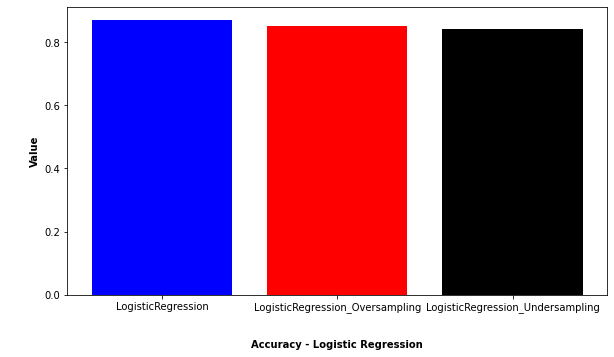

In [501]:
algorithms_comparison_plot(("LogisticRegression", "LogisticRegression_Oversampling", "LogisticRegression_Undersampling"), \
  "Accuracy - Logistic Regression", ['blue', 'red', 'black'], "accuracy")

### Precision

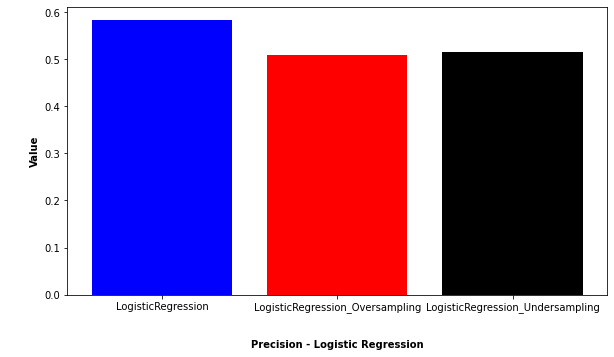

In [502]:
algorithms_comparison_plot(("LogisticRegression", "LogisticRegression_Oversampling", "LogisticRegression_Undersampling"), \
  "Precision - Logistic Regression", ['blue', 'red', 'black'], "precision")

### Recall

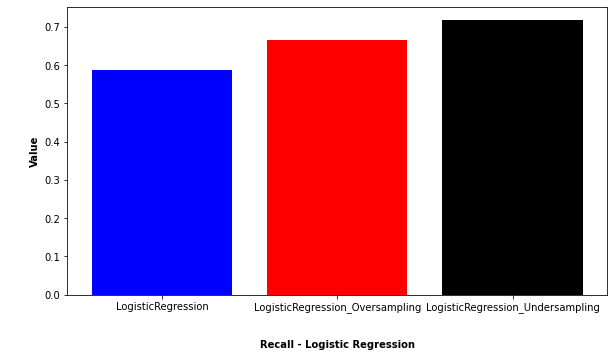

In [503]:
algorithms_comparison_plot(("LogisticRegression", "LogisticRegression_Oversampling", "LogisticRegression_Undersampling"), \
  "Recall - Logistic Regression", ['blue', 'red', 'black'], "recall")

### ROC-AUC

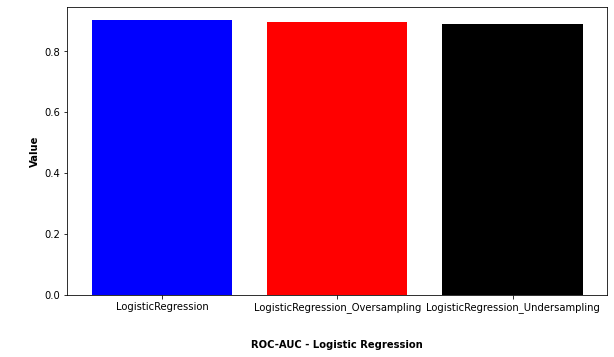

In [504]:
algorithms_comparison_plot(("LogisticRegression", "LogisticRegression_Oversampling", "LogisticRegression_Undersampling"), \
  "ROC-AUC - Logistic Regression", ['blue', 'red', 'black'], "roc_auc")

# Random Forest

### F1 Measure

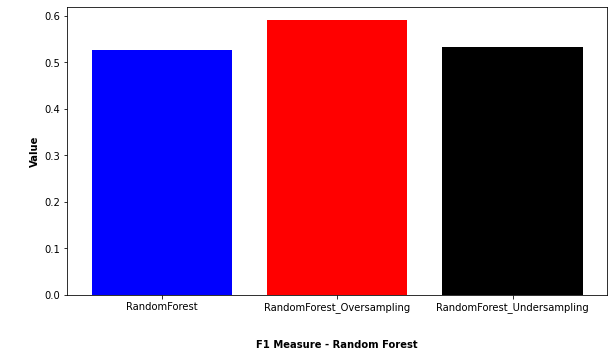

In [505]:
algorithms_comparison_plot(("RandomForest", "RandomForest_Oversampling", "RandomForest_Undersampling"), \
  "F1 Measure - Random Forest", ['blue', 'red', 'black'], "f1")

### Accuracy

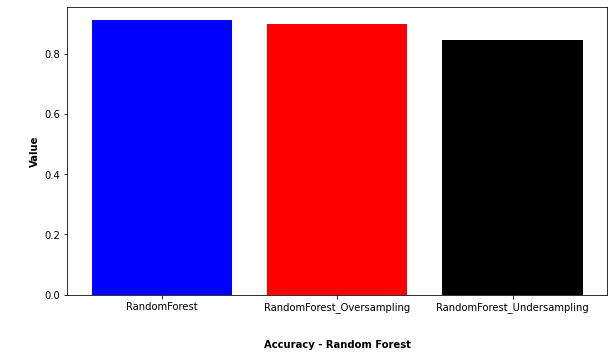

In [506]:
algorithms_comparison_plot(("RandomForest", "RandomForest_Oversampling", "RandomForest_Undersampling"), \
  "Accuracy - Random Forest", ['blue', 'red', 'black'], "accuracy")

### Precision

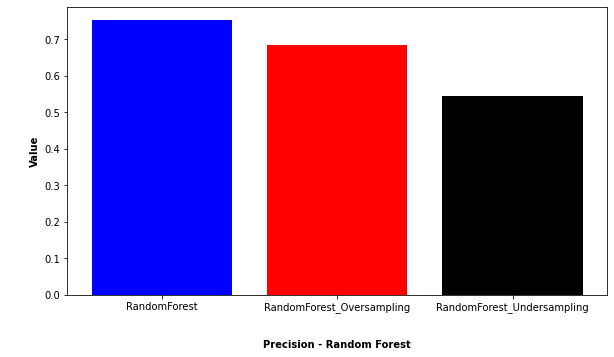

In [507]:
algorithms_comparison_plot(("RandomForest", "RandomForest_Oversampling", "RandomForest_Undersampling"), \
  "Precision - Random Forest", ['blue', 'red', 'black'], "precision")

### Recall

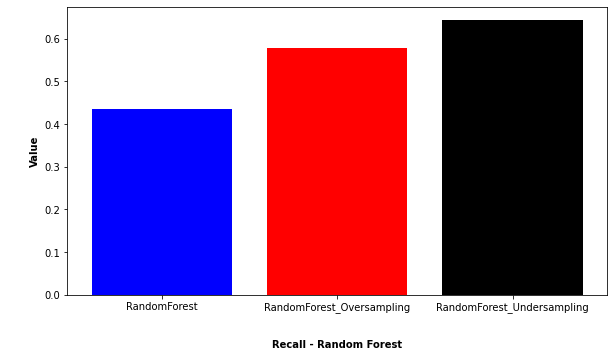

In [508]:
algorithms_comparison_plot(("RandomForest", "RandomForest_Oversampling", "RandomForest_Undersampling"), \
  "Recall - Random Forest", ['blue', 'red', 'black'], "recall")

### ROC-AUC

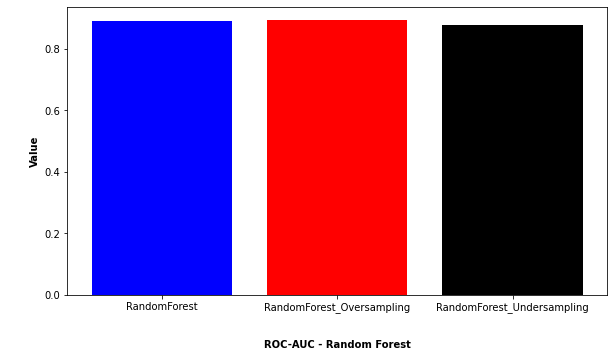

In [509]:
algorithms_comparison_plot(("RandomForest", "RandomForest_Oversampling", "RandomForest_Undersampling"), \
  "ROC-AUC - Random Forest", ['blue', 'red', 'black'], "roc_auc")

# SVM

### F1 Measure

In [510]:
algorithms_comparison_plot(("SVM", "SVM_Oversampling", "SVM_Undersampling"), \
  "F1 Measure - SVM", ['blue', 'red', 'black'], "f1")

KeyError: 'SVM_Oversampling'

### Accuracy

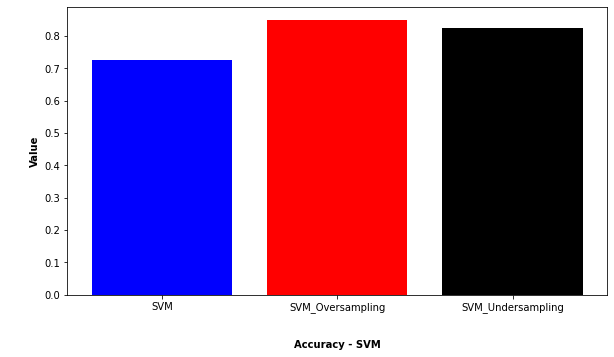

In [ ]:
algorithms_comparison_plot(("SVM", "SVM_Oversampling", "SVM_Undersampling"), \
  "Accuracy - SVM", ['blue', 'red', 'black'], "accuracy")

### Precision

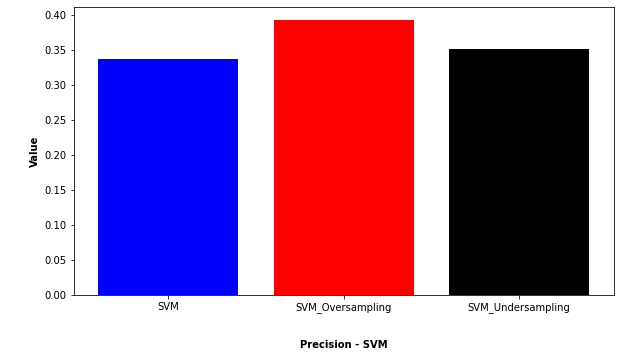

In [ ]:
algorithms_comparison_plot(("SVM", "SVM_Oversampling", "SVM_Undersampling"), \
  "Precision - SVM", ['blue', 'red', 'black'], "precision")

### Recall

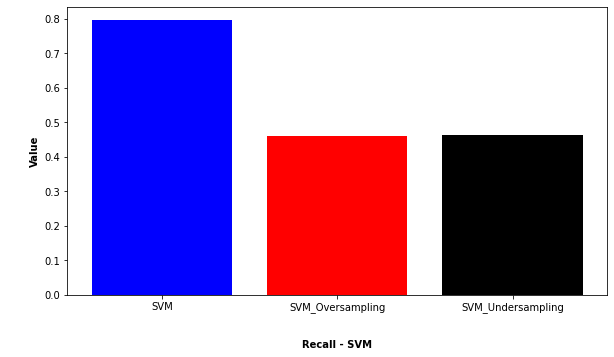

In [ ]:
algorithms_comparison_plot(("SVM", "SVM_Oversampling", "SVM_Undersampling"), \
  "Recall - SVM", ['blue', 'red', 'black'], "recall")

### ROC-AUC

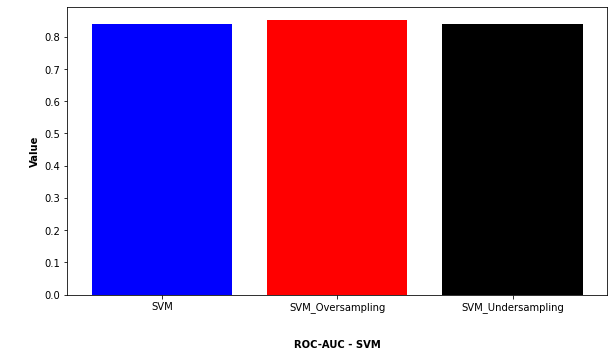

In [ ]:
algorithms_comparison_plot(("SVM", "SVM_Oversampling", "SVM_Undersampling"), \
  "ROC-AUC - SVM", ['blue', 'red', 'black'], "roc_auc")

# Light GBM

### F1 Measure

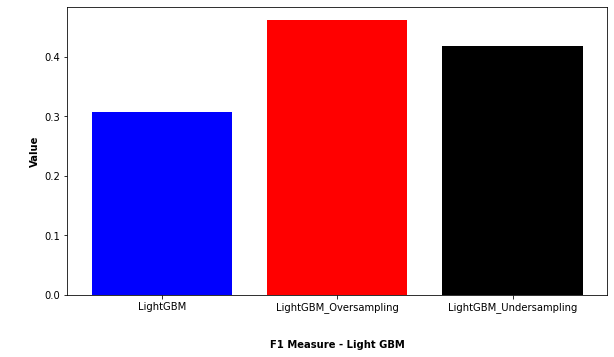

In [511]:
algorithms_comparison_plot(("LightGBM", "LightGBM_Oversampling", "LightGBM_Undersampling"), \
  "F1 Measure - Light GBM", ['blue', 'red', 'black'], "f1")

### Accuracy

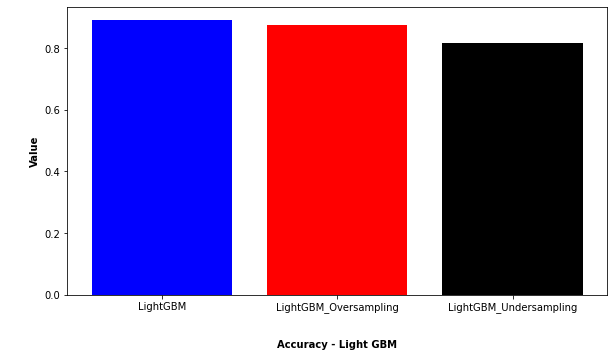

In [512]:
algorithms_comparison_plot(("LightGBM", "LightGBM_Oversampling", "LightGBM_Undersampling"), \
  "Accuracy - Light GBM", ['blue', 'red', 'black'], "accuracy")

### Precision

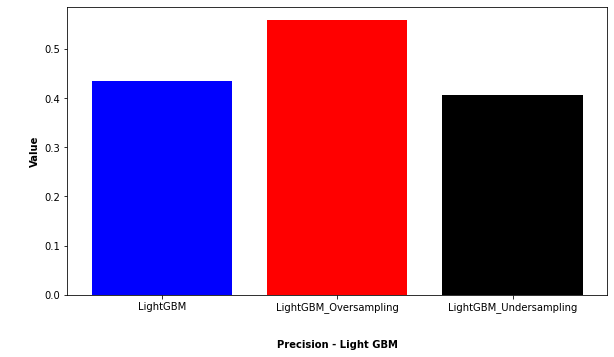

In [513]:
algorithms_comparison_plot(("LightGBM", "LightGBM_Oversampling", "LightGBM_Undersampling"), \
  "Precision - Light GBM", ['blue', 'red', 'black'], "precision")

### Recall

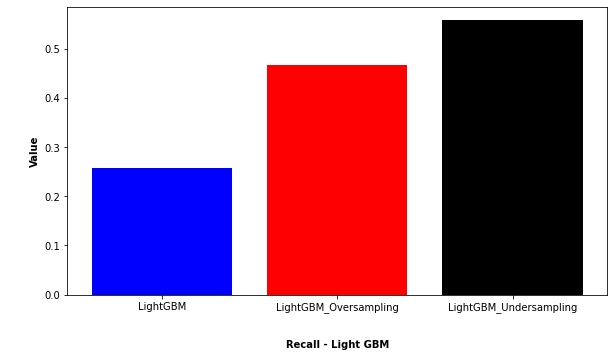

In [514]:
algorithms_comparison_plot(("LightGBM", "LightGBM_Oversampling", "LightGBM_Undersampling"), \
  "Recall - Light GBM", ['blue', 'red', 'black'], "recall")

### ROC-AUC

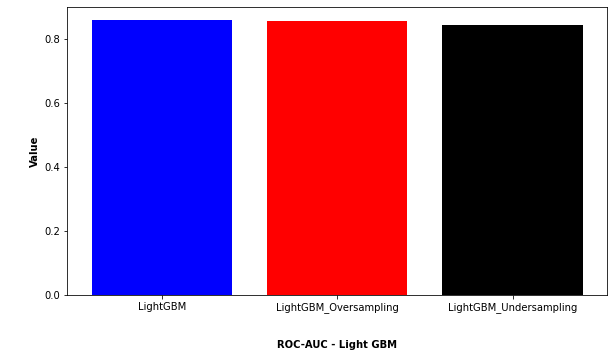

In [515]:
algorithms_comparison_plot(("LightGBM", "LightGBM_Oversampling", "LightGBM_Undersampling"), \
  "ROC-AUC - Light GBM", ['blue', 'red', 'black'], "roc_auc")

# Comparisons between best algorithms

In [516]:
best_algorithms = ("LogisticRegression", "RandomForest_Oversampling", "SVM_Undersampling", "LightGBM_Oversampling")
best_colors = ['blue', 'red', 'black', 'green']

### Fit time

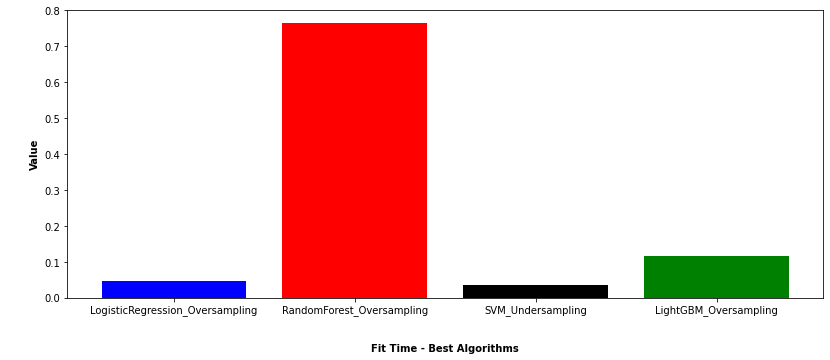

In [517]:
algorithms_comparison_plot(best_algorithms, "Fit Time - Best Algorithms", best_colors, "fit_time")

### F1 Measure

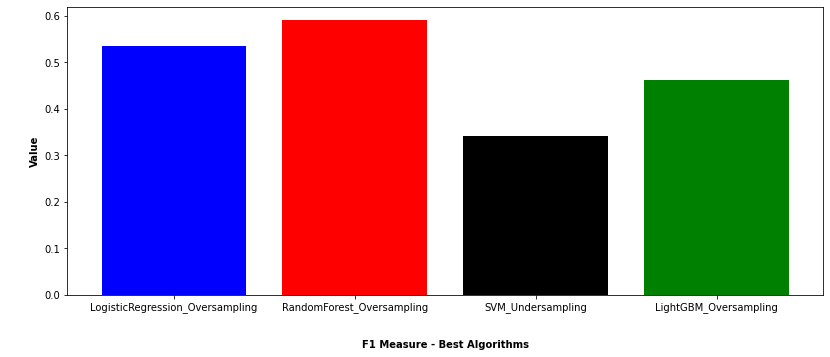

In [518]:
algorithms_comparison_plot(best_algorithms, "F1 Measure - Best Algorithms", best_colors, "f1")

### Accuracy

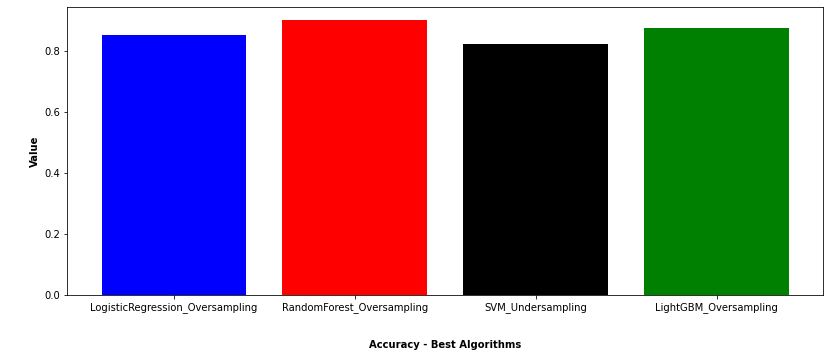

In [519]:
algorithms_comparison_plot(best_algorithms, "Accuracy - Best Algorithms", best_colors, "accuracy")

### Precision

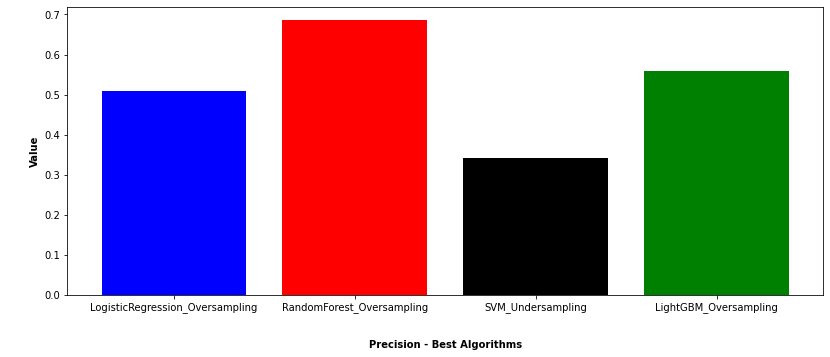

In [520]:
algorithms_comparison_plot(best_algorithms, "Precision - Best Algorithms", best_colors, "precision")

### Recall

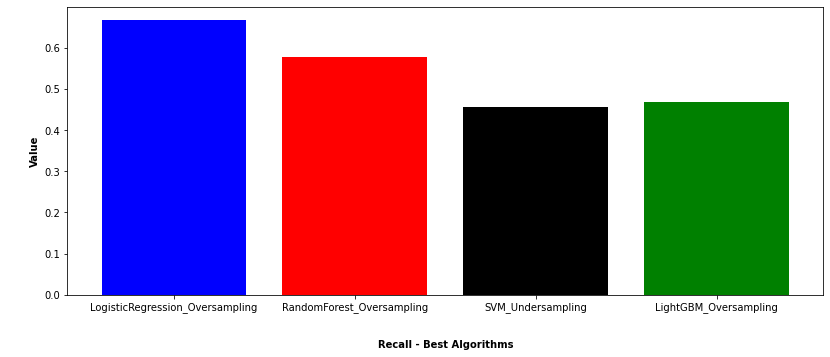

In [521]:
algorithms_comparison_plot(best_algorithms, "Recall - Best Algorithms", best_colors, "recall")

### ROC-AUC

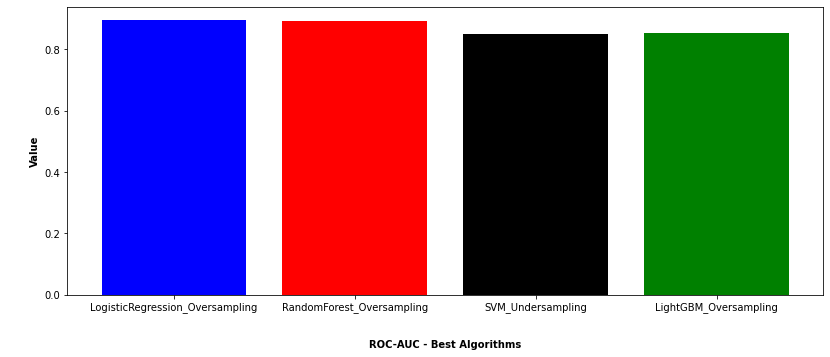

In [522]:
algorithms_comparison_plot(best_algorithms, "ROC-AUC - Best Algorithms", best_colors, "roc_auc")

# ROC Curve - Best Algorithms

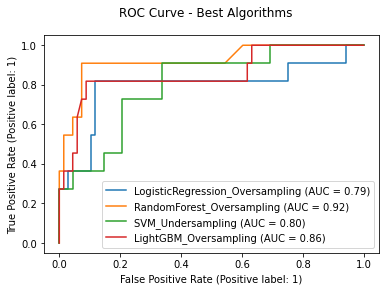

In [523]:
ax = None
for algorithm in best_algorithms:
  [estimator, X_train_plot, y_train_plot] = plots_data[algorithm]
  if ax is None:
    fig = RocCurveDisplay.from_estimator(estimator, X_train_plot, y_train_plot, name=algorithm)
  else:
    fig = RocCurveDisplay.from_estimator(estimator, X_train_plot, y_train_plot, name=algorithm, ax = fig.ax_)
  ax = fig.ax_

fig.figure_.suptitle("ROC Curve - Best Algorithms")
plt.show() 

# P-R Plot - Best Algorithms

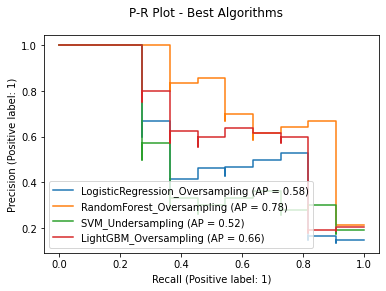

In [524]:
ax = None
for algorithm in best_algorithms:
  [estimator, X_train_plot, y_train_plot] = plots_data[algorithm]
  if ax is None:
    fig = PrecisionRecallDisplay.from_estimator(estimator, X_train_plot, y_train_plot, name=algorithm)
  else:
    fig = PrecisionRecallDisplay.from_estimator(estimator, X_train_plot, y_train_plot, name=algorithm, ax = fig.ax_)
  ax = fig.ax_

fig.figure_.suptitle("P-R Plot - Best Algorithms")
plt.show() 